# Код модели

In [35]:
from typing import Set, List, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt


In [47]:
class MarkowitzModel:
    """
    Markowitz Model for portfolio selection problem
    for N risk assets with\without 1 risk-free asset
    """

    def __init__(self, V: np.ndarray[float], e: np.ndarray[float], r: Tuple[float, float] | float = None):
        """
        keys:
        V -- covariance matrix (symmetric and positive definite)
        e -- expected return vector (non-negative elements, at least 2 of them differ)
        (optional)
        r -- lending and borrowing return rates of risk-free asset respectively, 0 <= r_lend <= r_borrow;
             can be just float in case r_lend = r_borrow
        """

        #check if input is correct
        if np.any(V != V.T) or not np.all(np.linalg.eigvals(V) > 0):
            raise ValueError("Incorrect matrix.")

        if np.any(e < 0) or len(np.unique(e)) == 1:
            raise ValueError("Incorrect expected return vector.")

        if r:
            if isinstance(r, tuple):
                if not 0 <= r[0] < r[1]:
                    raise ValueError("Incorrect returns of risk-free asset.")
                else:
                    self.__r = (float(r[0]), float(r[1]))
            elif r < 0:
                raise ValueError("Incorrect return of risk-free asset.")
            else:
                self.__r = float(r)
        else:
            self.__r = None

        self.__V = V.astype(float)
        self.__V_inv = None
        self.__e = e.astype(float)

        self.__std = None #std - function of expected return
        self.__w = None #w - portfolio weights, function of expected return
        self.__coeffs = dict()
        self.__mvp = None
        self.__touch_points = list()
        self.__fracture_points = list()

    def covariance_matrix(self) -> Tuple[np.ndarray[float], np.ndarray[float]]:
        return (self.__V, self.__V_inv)

    def return_vector(self) -> np.ndarray[float]:
        return self.__e

    def coeffs(self) -> Dict[str, float]:
        return self.__coeffs

    def r(self) -> Tuple[float, float] | float:
        return self.__r

    def fracture_points(self) -> List[np.ndarray[float]]:
        return self.__fracture_points

    def touch_points(self) -> List[np.ndarray[float]]:
        return self.__touch_points

    def mvp(self) -> np.ndarray[float]:
        return self.__mvp

    def std(self, x: np.ndarray[float] | float) -> np.ndarray[float] | float:
        if isinstance(x, float):
            return self.__std(x)
        else:
            return np.array([self.__std(elem) for elem in x])

    def efficient_portfolio(self, e: float) -> Tuple[np.ndarray[float], float]:
        '''
        gives best portfolio for given expected return and its std
        '''
        if self.__r is None:
            return (self.__w(e), self.__std(e))
        else:
            w = self.__w(e)
            return (np.array(list(w) + [1 - w.sum()]), self.__std(e))

    def __H(self, A: float, B: float, C: float, r: float) -> float:
        '''
        Computes H coefficient
        '''
        return C * (r ** 2) - 2 * A * r + B

    def __compute_coeffs(self):
        """
        computes coefficients of equations (A, B, C, D, H \ Hl and Hb)
        and saves it in dict self.__coeffs
        """
        I = np.ones(len(self.__e))
        self.__coeffs['A'] = I.T @ self.__V_inv @ self.__e
        self.__coeffs['B'] = self.__e.T @ self.__V_inv @ self.__e
        self.__coeffs['C'] = I.T @ self.__V_inv @ I
        self.__coeffs['D'] = self.__coeffs['B'] * self.__coeffs['C'] - self.__coeffs['A'] ** 2
        if self.__r:

            if isinstance(self.__r, tuple):
                self.__coeffs['Hl'] = self.__H(self.__coeffs['A'], self.__coeffs['B'], self.__coeffs['C'], self.__r[0])
                self.__coeffs['Hb'] = self.__H(self.__coeffs['A'], self.__coeffs['B'], self.__coeffs['C'], self.__r[1])
            else:
                self.__coeffs['H'] = self.__H(self.__coeffs['A'], self.__coeffs['B'], self.__coeffs['C'], self.__r)


    def __hyperbola(self, x: float | np.ndarray, output: str) -> float | np.ndarray[float]:
        """
        decision without risk-free asset (x - expected return value)
        returns standard deviation or weights of efficient portfolio (depends on output: "w" or "std")
        """
        A = self.__coeffs['A']
        B = self.__coeffs['B']
        C = self.__coeffs['C']
        D = self.__coeffs['D']
        I = np.ones(len(self.__e))
        if output == "std":
            var = (C * x ** 2 - 2 * A * x + B) / D
            return np.sqrt(var)
        else:
            w = self.__V_inv @ ((C * x - A) * self.__e + (B - A * x) * I) / D
            return w


    def __line(self, x: float, r: float, H: float, output: str) ->  float | np.ndarray[float]:
        """
        line: x = +\- sqrt(H) * std + r (x - expected return rate)
        returns standard deviation or weights of efficient portfolio (depends on output: "w" or "std")
        """
        I = np.ones(len(self.__e))
        Hs = np.sqrt(H)
        if output == "std":
            std = -(x - r) / Hs if x <= r else (x - r) / Hs
            return std
        else:
            w = (x - r) / H * self.__V_inv @ (self.__e - r * I)
            return w


    def find_frontier(self):
        """
        finds function std(expected return) and w(expected return)
        """
        self.__V_inv = np.linalg.inv(self.__V)
        self.__compute_coeffs()

        A = self.__coeffs['A']
        B = self.__coeffs['B']
        C = self.__coeffs['C']
        self.__mvp = np.array([np.sqrt(1 / C), A / C])

        # case of N risk assets
        if self.__r is None:
            self.__std = lambda x: self.__hyperbola(x, "std")
            self.__w = lambda x: self.__hyperbola(x, "w")

        # case of risk free asset with r_lend = r_borrow = r
        elif isinstance(self.__r, float):
            H = self.__coeffs['H']
            self.__std = lambda x: self.__line(x, self.__r, H, "std")
            self.__w = lambda x: self.__line(x, self.__r, H, "w")
            if self.__r != A / C:
                #save touch point
                x = - np.sqrt(H) / (A - self.__r * C) if self.__r > A/C else np.sqrt(H) / (A - self.__r * C)
                y = (B - A * self.__r) / (A - C * self.__r)
                self.__touch_points.append(np.array([x, y]))

        #case of 2 differents return rates
        else:
            Hl = self.__coeffs['Hl']
            Hb = self.__coeffs['Hb']
            rl = self.__r[0]
            rb = self.__r[1]
            Hls = np.sqrt(Hl)
            Hbs = np.sqrt(Hb)

            #touch and fracture points
            if Hb != Hl:
                x = (rb - rl) / (Hbs - Hls)
                y = (Hbs * rl - Hls * rb) / (Hbs - Hls)
                e = y
            if rl != A/C:
                xl = Hls / (A - rl * C)
                yl = (B - rl * A) / (A - rl * C)
                el = yl

            if rb != A/C:
                xb = Hbs / (A - rb * C)
                yb = (B - rb * A) / (A - rb * C)
                eb = yb


            if A/C <= rl:
                #save fracture point P
                self.__fracture_points.append(np.array([x, y]))

                def f(x, output):
                    if x <= e:
                        return self.__line(x, rb, Hb, output)
                    else:
                        return self.__line(x, rl, Hl, output)
                    return var
                self.__std = lambda x: f(x, "std")
                self.__w = lambda x: f(x, "w")

            elif rl < A/C <= rb:

                if Hb > Hl:
                    self.__fracture_points.append(np.array([x, y]))
                    self.__touch_points.append(np.array([xl, yl]))

                    def f(x, output):
                        if x <= e:
                            return self.__line(x, rb, Hb, output)
                        elif x <= el:
                            return self.__line(x, rl, Hl, output)
                        else:
                            return self.__hyperbola(x, output)
                    self.__std = lambda x: f(x, "std")
                    self.__w = lambda x: f(x, "w")

                else:
                    self.__touch_points.append(np.array([xl, yl]))

                    def f(x, output):
                        if x <= el:
                            return self.__line(x, rl, Hl, output)
                        else:
                            return self.__hyperbola(x, output)
                    self.__std = lambda x: f(x, "std")
                    self.__w = lambda x: f(x, "w")

            elif rb < A/C:

                #2 touch points
                self.__touch_points.append(np.array([xl, yl]))
                self.__touch_points.append(np.array([xb, yb]))

                def f(x, output):
                    if x <= el:
                        return self.__line(x, rl, Hl, output)
                    elif x <= eb:
                        return self.__hyperbola(x, output)
                    else:
                        return self.__line(x, rb, Hb, output)

                self.__std = lambda x: f(x, "std")
                self.__w = lambda x: f(x, "w")

    def plot_frontier(self, std_lim: float, e_lim: float):
        A = self.__coeffs['A']
        B = self.__coeffs['B']
        C = self.__coeffs['C']
        D = self.__coeffs['D']

        plt.figure(figsize=(10, 6))
        plt.xlabel("standard deviation")
        plt.ylabel("expected return")
        emin = 2 * A/C - e_lim
        emax = e_lim

        y = np.linspace(emin, emax, 1000) #for symmetry
        x = self.__hyperbola(y, output="std")

        if self.__r is None:
            plt.plot(x, y, linewidth=2, color='deeppink', zorder=0, label='frontier')
            x_as = list(map(lambda t: self.__line(t, A/C, D/C, "std"), y))
            plt.plot(x_as, y, color='lightpink', linestyle='--')

        else:
            plt.plot(x, y, linewidth=2, color="grey", zorder=0)
            x = list(map(lambda t: self.__std(t), y))
            plt.plot(x, y, linewidth=2, color='deeppink', zorder=0, label='frontier')
            #add touch and fracture points
            labelt = 'touch point'
            labelf = 'fracture point'
            for point in self.__touch_points:
                plt.scatter(point[0], point[1], marker='o', s=30, color='purple', zorder=1, label=labelt)
                plt.axvline(x=point[0], ymax=(point[1] - emin)/(emax - emin), color='purple', linestyle=':', zorder=1)
                plt.axhline(y=point[1], xmax = point[0] / std_lim, color='purple', linestyle=':', zorder=0)
                labelt = None

            for point in self.__fracture_points:
                plt.scatter(point[0], point[1], marker='o', s=30, color='navy', zorder=1, label=labelf)
                plt.axvline(x=point[0], ymax=(point[1] - emin)/(emax - emin), color='navy', linestyle=':', zorder=1)
                plt.axhline(y=point[1], xmax = point[0] / std_lim, color='navy', linestyle=':', zorder=0)
                labelf = None


        #add mvp point
        plt.axvline(x=self.__mvp[0], ymax =(self.__mvp[1] - emin)/(emax - emin), color='black', linestyle=':', zorder=1)
        plt.axhline(y=self.__mvp[1], xmax = self.__mvp[0] / std_lim, color='black', linestyle=':', zorder=1)
        plt.scatter(self.__mvp[0], self.__mvp[1], marker='o', s=30, c='black', label="mvp", zorder=1)
        plt.xlim(0, std_lim)
        plt.ylim(emin, emax)
        plt.legend()
        plt.title("Portfolio Frontier")
        plt.show()

# Пример использования кода

In [48]:
V = np.array([[10, 2, 0, 1, 2], [2, 30, 1, 1, 3], [0, 1, 5, 0, -4], [1, 1, 0, 17, -2], [2, 3, -4, -2, 100]])
e = np.array([4, 6, 1, 2, 3])
m = MarkowitzModel(V, e)
m.find_frontier()

In [49]:
coeffs = m.coeffs()
coeffs

{'A': 0.8238894932778054,
 'B': 2.8490817710827483,
 'C': 0.38698201026913626,
 'D': 0.4237494940611942}

In [50]:
m.efficient_portfolio(3)

(array([0.35856091, 0.14587201, 0.33775499, 0.12066697, 0.03714512]),
 1.8102197990676494)

In [52]:
m.std(3.)

1.8102197990676494

In [53]:
x = np.array([1, 2, 3.5])
m.std(x)

array([1.9360189 , 1.61223431, 2.07379328])

# Проверка случаев

##1. Только рисковые активы

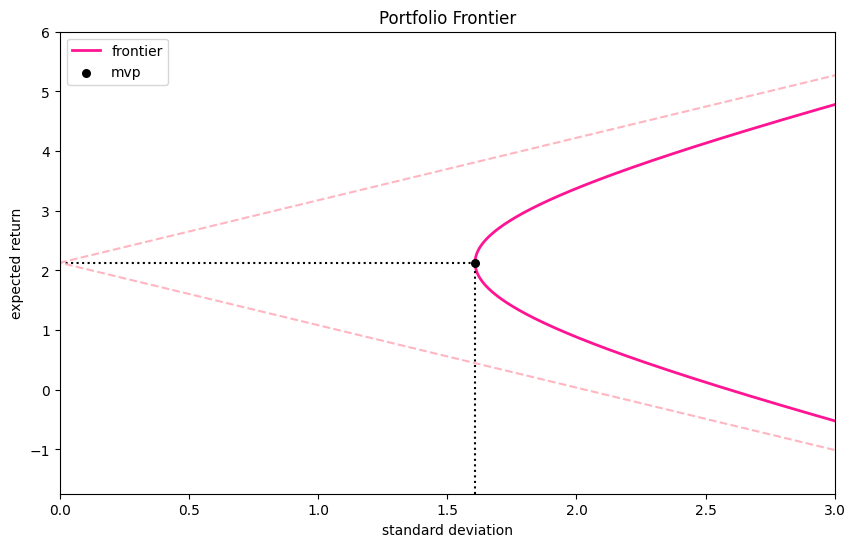

In [54]:
m = MarkowitzModel(V, e)
m.find_frontier()
m.plot_frontier(std_lim=3, e_lim=6)

In [11]:
m.efficient_portfolio(3)

(array([0.35856091, 0.14587201, 0.33775499, 0.12066697, 0.03714512]),
 1.8102197990676494)

## 2. Рисковый актив с одинаковой ставкой доходности

### 2.1  r > $\frac{A}{C}$

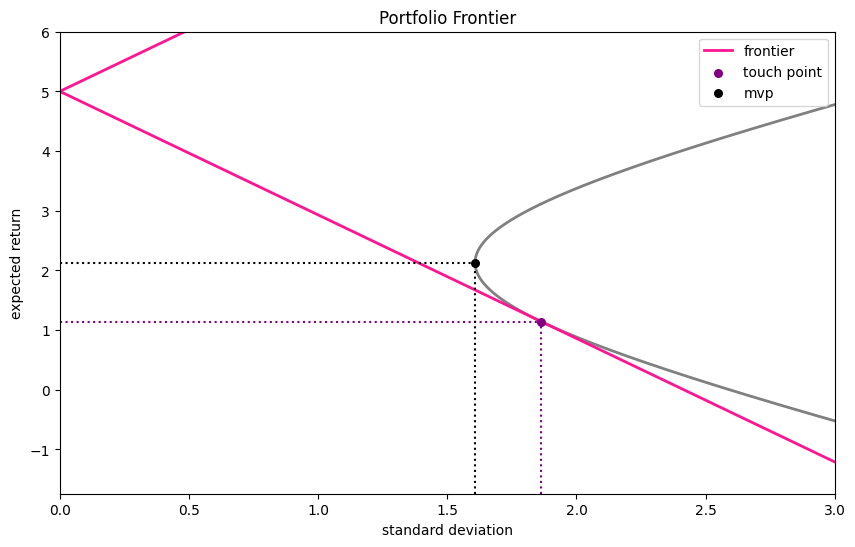

In [55]:
m = MarkowitzModel(V, e, 5)
m.find_frontier()
m.plot_frontier(std_lim=3, e_lim=6)

In [13]:
m.efficient_portfolio(3)

(array([ 0.04008986, -0.03725536,  0.40284877,  0.08543723,  0.02747402,
         0.48140549]),
 0.966201941771265)

### 2.2 r = $\frac{A}{C}$

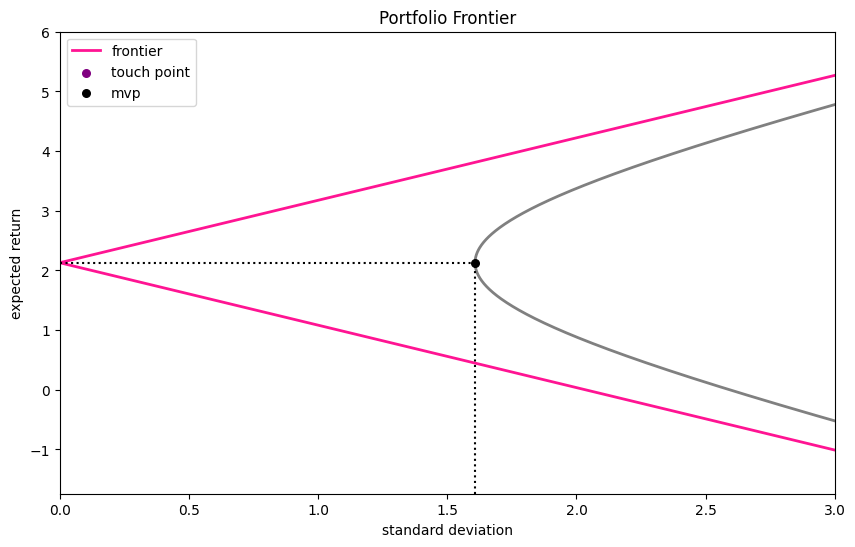

In [56]:
m = MarkowitzModel(V, e, 2.129)
m.find_frontier()
m.plot_frontier(std_lim=3, e_lim=6)

In [15]:
m.efficient_portfolio(3)

(array([ 0.13195012,  0.10213776, -0.20597684, -0.02067959, -0.00742764,
         0.99999619]),
 0.8323556786811861)

### 2.3 r < $\frac{A}{C}$

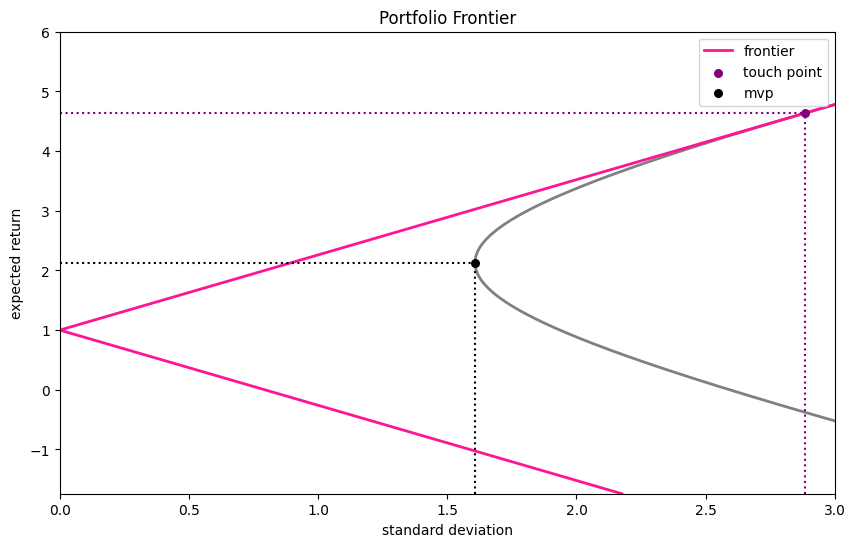

In [57]:
m = MarkowitzModel(V, e, 1)
m.find_frontier()
m.plot_frontier(std_lim=3, e_lim=6)

In [17]:
m.efficient_portfolio(3)

(array([ 0.33356006,  0.18575346, -0.02693988,  0.0450255 ,  0.01276351,
         0.44983735]),
 1.586959364968624)

## 3. Различные ставки

###3.1  $ \frac{A}{C}$ < rl < rb

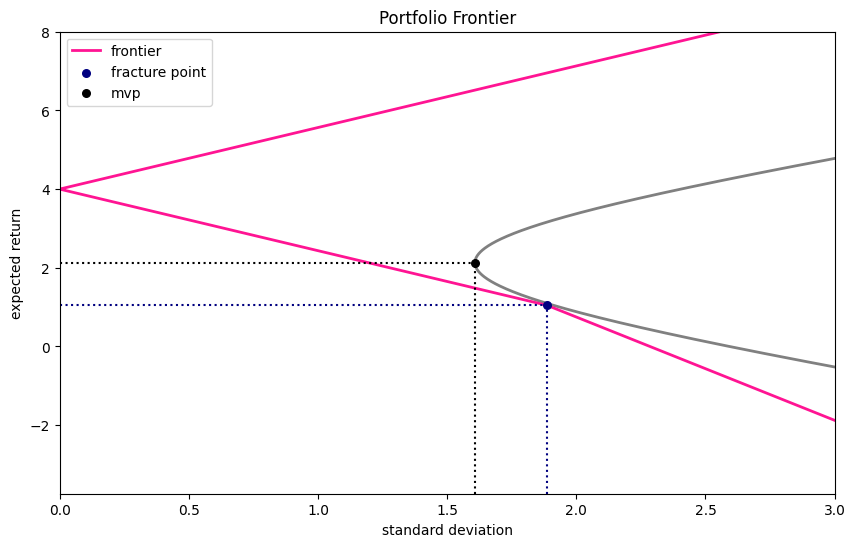

In [58]:
m = MarkowitzModel(V, e, (4, 6))
m.find_frontier()
m.plot_frontier(std_lim=3, e_lim=8)

In [19]:
m.efficient_portfolio(3)

(array([-0.0007381 , -0.03949079,  0.26641723,  0.0523903 ,  0.01698615,
         0.70443522]),
 0.6389185538686617)

###3.2  $ \frac{A}{C}$ = rl < rb

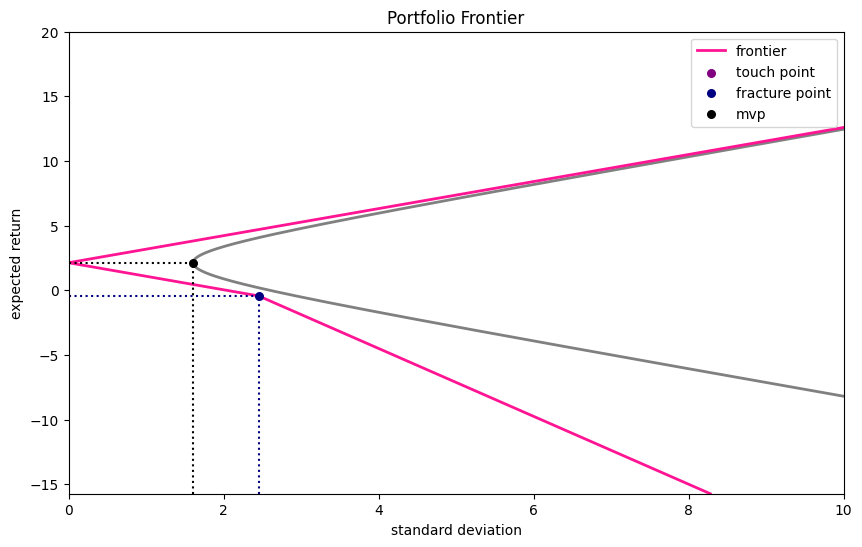

In [59]:
m = MarkowitzModel(V, e, (2.129, 6))
m.find_frontier()
m.plot_frontier(std_lim=10, e_lim=20)

In [22]:
m.touch_points()

[array([218305.2571865 , 228442.78709789])]

In [23]:
m.efficient_portfolio(3)

(array([ 0.13195012,  0.10213776, -0.20597684, -0.02067959, -0.00742764,
         0.99999619]),
 0.8323556786811861)

###3.3  rl < $ \frac{A}{C}$ <= rb

#### 3.3.1 Hb > Hl

In [66]:
m = MarkowitzModel(V, e, (1, 5))
m.find_frontier()
m.coeffs()

{'A': 0.8238894932778054,
 'B': 2.8490817710827483,
 'C': 0.38698201026913626,
 'D': 0.4237494940611942,
 'Hl': 1.588284794796274,
 'Hb': 4.284737095033099}

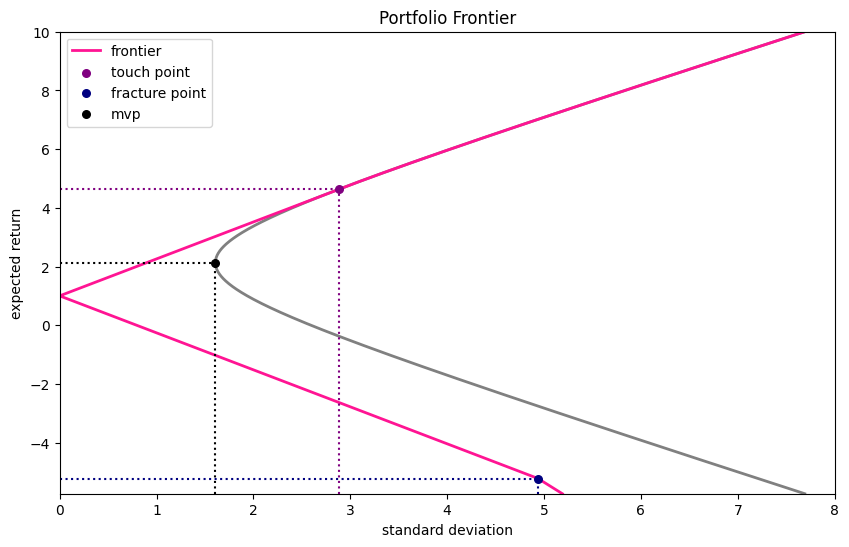

In [67]:
m.plot_frontier(std_lim=8, e_lim=10)

In [26]:
m.fracture_points()

[array([ 4.94016878, -5.22595497])]

#### 3.3.2 Hb <= Hl

In [68]:
m = MarkowitzModel(V, e, (1, 2.5))
m.find_frontier()
m.coeffs()

{'A': 0.8238894932778054,
 'B': 2.8490817710827483,
 'C': 0.38698201026913626,
 'D': 0.4237494940611942,
 'Hl': 1.588284794796274,
 'Hb': 1.1482718688758227}

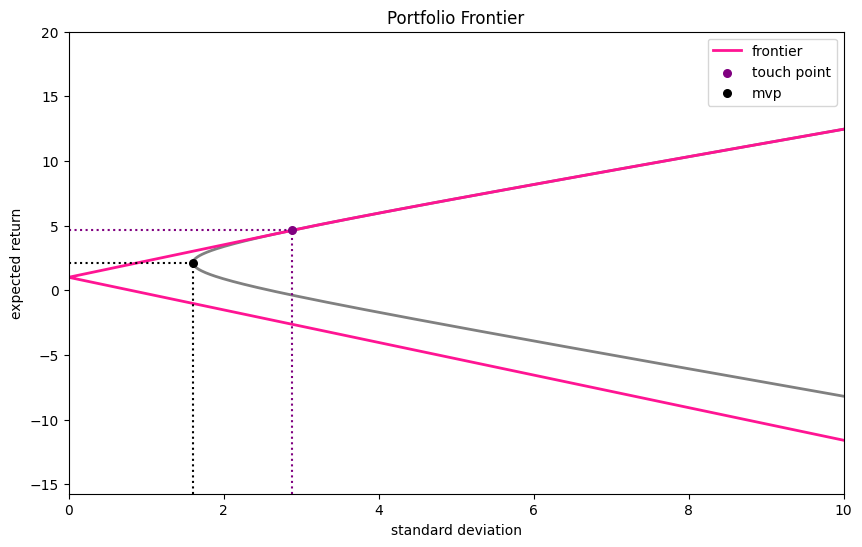

In [69]:
m.plot_frontier(std_lim=10, e_lim=20)

###3.4 rl < rb < $\frac{A}{C}$



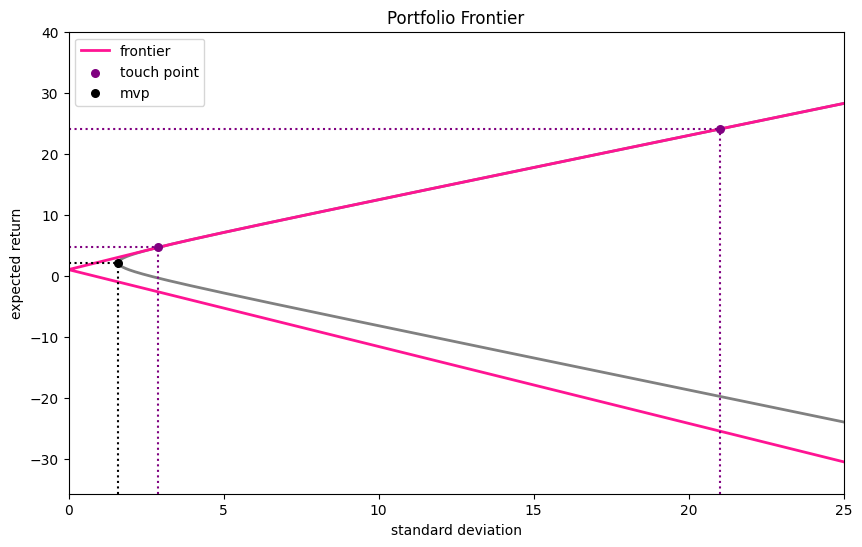

In [70]:
m = MarkowitzModel(V, e, (1, 2))
m.find_frontier()
m.plot_frontier(std_lim=25, e_lim=40)

In [71]:
m.touch_points()

[array([2.88452765, 4.63528861]), array([21.02134841, 24.06192107])]